In [237]:
import os
import numpy as np
import matplotlib.pyplot as plt
from gensim.models.word2vec import PathLineSentences, LineSentence, Word2Vec
from pathlib import Path
import networkx as nx
from sklearn import model_selection, linear_model, preprocessing, svm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
%matplotlib inline


**Load random walks from output files**

The word2vec model requires sentences of strings, so we convert node number to a string.

In [238]:
rw_location = Path("/Users/Ganymedian/Desktop/dynamic-rw/karate/ar")
methods = ["m1", "m2", "m3", "m4"]
# methods = ["m1", "m2", "m4"]
nmethods = len(methods)
vertices = []
for i in range(34):
    vertices.append("v"+str(i+1))
# v = vertices[0]
v="v30"

num_runs = 5

In [239]:
# G = nx.karate_club_graph()
G = nx.read_edgelist("/Users/Ganymedian/Desktop/Projects/stellar-random-walk-research/randomwalk/src/test/resources/karate.txt", nodetype=int)
n_nodes = G.number_of_nodes()
A = nx.adjacency_matrix(G,nodelist=sorted(G.nodes())).toarray()
d_w = A.sum(axis=1)
M_theory = A.T / d_w
# print(M_theory)
# print(M_theory.T)

In [240]:
random_walks_int = []

for m in methods:
    fname = m
    if m != "m1":
        fname = fname+"-"+v
    print(fname)
    rws = np.concatenate([
        np.loadtxt(f.open(), delimiter='\t', dtype=int)
        for f in rw_location.glob(fname+"-*/part-00000")
        if f.stat().st_size > 0
    ])
    print(rws.shape)
    random_walks_int.append(rws)
#     random_walks_str = [list(map(str, v)) for v in random_walks_int]

m1
(17000, 101)
m2-v30
(17000, 101)
m3-v30
(17000, 101)
m4-v30
(17000, 101)


In [241]:
all_runs = []
print(num_runs)
for i in range(nmethods):
    ars = np.vsplit(random_walks_int[i], 5)
    print(ars[0].shape)
    all_runs.append(ars)


5
(3400, 101)
(3400, 101)
(3400, 101)
(3400, 101)


Calculate empirical transition probabilities

[0.07530372 0.05367405 0.04025912 0.03715316 0.03548778 0.03117355
 0.02704039 0.02442425 0.02335888 0.02113526 0.01958094 0.02046776
 0.02027333 0.01980224 0.02080996 0.02194868 0.02075485 0.02145743
 0.02057328 0.02031355]
[0.07686786 0.05407537 0.03994353 0.0346536  0.02924173 0.0269507
 0.02617087 0.02476991 0.02336892 0.02432452 0.02081327 0.01914994
 0.01928512 0.01866413 0.01821189 0.01693922 0.01699512 0.01639165
 0.01590079 0.01484948]
[0.08089598 0.04918749 0.03894282 0.03292232 0.03039724 0.02943746
 0.02767331 0.02680824 0.02287642 0.02248165 0.02055824 0.02007092
 0.01929537 0.0184708  0.01616062 0.01657279 0.01677743 0.01566425
 0.01463314 0.01422713]
[0.07738206 0.04920182 0.03506882 0.03652837 0.02799146 0.02762409
 0.02421026 0.02200976 0.02045774 0.01949131 0.01883463 0.01793487
 0.016211   0.01595344 0.01623555 0.01659961 0.01772554 0.01732925
 0.01690108 0.01619912]


<function matplotlib.pyplot.show>

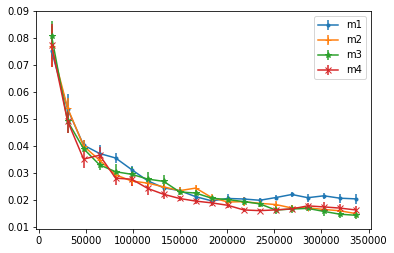

In [242]:
formats=['.-', '+-', '*-','x-']
for mm in range(nmethods):
    all_errors = []
    for rr in range(num_runs):
        errors = []
        x_axis = []
        for ii in range(20):
            walk_length = 5*(ii + 1)

            M_empirical = np.zeros((n_nodes, n_nodes))
            for walk in all_runs[mm][rr]:
                for kk in range(walk_length - 1):
                    M_empirical[walk[kk] - 1, walk[kk + 1] - 1] += 1

            n_samples = M_empirical.sum()
            M_empirical = M_empirical.T / np.maximum(M_empirical.sum(axis=1), 1)

            errors.append(np.abs(M_theory - M_empirical).max())
            x_axis.append(n_samples)
        all_errors.append(errors)
    n = len(all_errors)
    means = np.mean(all_errors,axis=0)
    print(means)
    stdv = np.std(all_errors, axis=0)
    stderr = stdv/np.sqrt(n)
    plt.errorbar(x_axis, means, yerr=stderr, fmt=formats[mm], label=methods[mm])
    plt.legend()
plt.show
# plt.plot(x_axis, all_errors, '.-')

0.9395079594790159
0.028741502372561713
3.3536124073059748


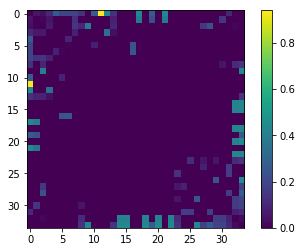

In [117]:
plt.imshow(np.abs(M_theory - M_empirical))
plt.colorbar()
error = np.abs(M_theory - M_empirical).max()
print(error)
error = np.abs(M_theory - M_empirical).mean()
print(error)
error = np.linalg.norm(M_theory - M_empirical)
print(error)

In [ ]:
errors_nw = []
x_axis_nw = []
walk_length = random_walks_int.shape[1]
for ii in range(20):
    #walk_length = 5*(ii + 1)
    #walk_lengths.append(walk_length)
    
    num_walks = 5*(ii + 1)

    reduced_walks = []
    for kk in range(1, n_nodes+1):
        reduced_walks.append(
            random_walks_int[random_walks_int[:, 0] == kk][:num_walks]
        )
    reduced_walks = np.concatenate(reduced_walks)
    
    M_empirical = np.zeros((n_nodes, n_nodes))
    for walk in reduced_walks:
        for kk in range(walk_length - 1):
            M_empirical[walk[kk] - 1, walk[kk + 1] - 1] += 1
    n_samples = M_empirical.sum()
    M_empirical = M_empirical.T / np.maximum(M_empirical.sum(axis=1), 1)

    errors_nw.append(np.abs(M_theory - M_empirical).max())
    x_axis_nw.append(n_samples)

plt.plot(x_axis_nw, errors_nw, '.-')
plt.plot(x_axis, errors, '--')

In [ ]:
import sys
sys.path.append("/Users/doc019/Code/stellar-evaluation-plugins")
from utils.epgm import EPGM

Theoretical transition probabilities

In [ ]:
error = np.abs(M_theory - M_empirical).max()
#error = np.linalg.norm(M_theory - M_empirical)
error

Train word2vec embeddings using gensim

In [ ]:
model = Word2Vec(random_walks_str, sg=1, size=20, window=5, sample=0, min_count=0, 
                 workers=4, seed=1321, iter=10, compute_loss=True)

In [ ]:
model.get_latest_training_loss()

Save embeddings

In [ ]:
model.wv.save_word2vec_format("embeddings.out")

Extract embeddings as matrix of size `n_nodes` × `d`

In [ ]:
V_w2v = model.wv.syn0
n_nodes, d_emb = V_w2v.shape

Node labels:

In [ ]:
node_labels = np.zeros(n_nodes)
node_labels[:10] = 1

**Classification using single train/test split**

In [ ]:
# Split using sklearn ShuffleSplit
ss = model_selection.ShuffleSplit(n_splits=1,
                                  train_size=0.6,
                                  test_size=0.4)
train_index, test_index = next(ss.split(V_w2v))

train_data = V_w2v[train_index]
test_data = V_w2v[test_index]
train_labels = node_labels[train_index]
test_labels  = node_labels[test_index]

# Classifier choice
#classifier = linear_model.LogisticRegression(C=10)
classifier = svm.SVC(C=1)

clf = make_pipeline(preprocessing.StandardScaler(), classifier)
clf.fit(train_data, train_labels)

train_pred = clf.predict(train_data)
test_pred = clf.predict(test_data)

print("Train acc:", clf.score(train_data, train_labels))
print("Test acc:", clf.score(test_data, test_labels))
print("Train f1:", f1_score(train_labels, train_pred, average='micro'))
print("Test f1:", f1_score(test_labels, test_pred, average='micro'))

**K-fold cross validation**

In [ ]:
kf = model_selection.KFold(n_splits=4, shuffle=True)

acc_test_scores = []
f1_test_scores = []
for train_index, test_index in kf.split(V_w2v):
    train_data = V_w2v[train_index]
    test_data = V_w2v[test_index]
    train_labels = node_labels[train_index]
    test_labels  = node_labels[test_index]
    
    # Classifier choice
    #classifier = linear_model.LogisticRegression(C=10)
    classifier = svm.SVC(C=1)

    clf = make_pipeline(preprocessing.StandardScaler(), classifier)
    clf.fit(train_data, train_labels)

    train_pred = clf.predict(train_data)
    test_pred = clf.predict(test_data)

    acc_train = clf.score(train_data, train_labels)
    acc_test = clf.score(test_data, test_labels)
    f1_train = f1_score(train_labels, train_pred, average='micro')
    f1_test = f1_score(test_labels, test_pred, average='micro')
    
    acc_test_scores.append(acc_test)
    f1_test_scores.append(f1_test)
    
    print("Train acc={:4f},  Test acc={:4f},  Train f1={:4f},  Test f1={:4f}".format(
        acc_train, acc_test, f1_train, f1_test
    ))
    
print("Average scores:")
print("Avg test acc={:4f} [±{:2f}],  Avg test f1={:4f} [±{:2f}]".format(
    np.mean(acc_test_scores), np.std(acc_test_scores), 
    np.mean(f1_test_scores), np.std(f1_test_scores)
))